# Анализ данных ЭЭГ

Где лежат данные?

- папка `./EEG RAW DATA (INFOPOVODI)`

в этой папке есть три файла для каждого респондента:
1. `1_RAW DATA` - это файл с сырыми данными с момента, как мы включили
запись ЭЭГ до момента, когда мы её выключили. Он нам важен, потому
что там есть данные по эмоциональным метрикам (stress, interest,
engagement, и т.д.).
2. `1_Восприятие инфоповодов_RAW` - это файл с сырыми данными самого
эксперимента (то есть он обрезан с момента, как мы включили сам
эксперимент и до момента, когда мы его выключили)
3. `1_Восприятие инфоповодов_intervalMarker.csv` - это файл с маркерами
событий, в том числе и самих стимулов.

**ВАЖНО**: для пилотного респондента есть только два файла: 0_RAW DATA
и 0_Восприятие инфоповодов (basic pre-processing): второй файл - это
файл, полученный с предобработки Emotiv, из него можно взять
таймстемпы для сырых данных.

### Импорт библиотек

In [523]:
import os
import glob
import warnings
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy import signal

from pathlib import Path
import random

# фикс сида для воспроизводимости
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

## Задача 1: ERP-графики
Что должно получиться? 24 графика вызванных потенциалов для каждого
стимула для всех респондентов по всем отведениям

Какие подзадачи могут входить:
1. Предобработка ЭЭГ-сигналов (фильтрация, удаление артефактов,
референсирование и т.д.)
2. ERP-обработка
Указание интервала усреднения:
До стимула (предстимульный интервал, baseline) — 200 мс
После стимула — 1000 мс
Базовая коррекция по предстимульному интервалу
усреднение по каждому типу стимула
проверкаx потенциалов по каждому респонденту (в итоговом варианте
графики по каждому респонденту не нужны)
4. визуализация: итоговые графики вызванных потенциалов
в итоговом варианте нужны только графики по всем респондентам (т.е.
необходимо сделать усреднение по респондентам) для каждого стимула
(всего 24 стимула: среди них инфоповоды, комментарии, ответы к
комментариям на платформах ВКонтакте и Телеграм)

In [526]:
base_dir = Path("./EEG RAW DATA (INFOPOVODI)")

markers_path = base_dir / "1_Восприятие инфоповодов_intervalMarker.csv"

eeg_exp_path = base_dir / "1_Восприятие инфоповодов_RAW.csv"

eeg_full_path = base_dir / "1_RAW DATA.csv"

# чтение маркеров
markers = pd.read_csv(markers_path)
print("Markers columns:", markers.columns.tolist())
print("Markers head():")
markers.head()

Markers columns: ['latency', 'duration', 'type', 'marker_value', 'key', 'timestamp', 'marker_id']
Markers head():


,latency,duration,type,marker_value,key,timestamp,marker_id
0,0.257672,3.341933,sensor_check,true,-1,1.743410e+09,1
1,3.599605,0.000000,published_date,2025-03-25T16:42:13.603854Z,-1,1.743410e+09,2
2,3.599605,9.916485,phase_calibration,calibration,-1,1.743410e+09,3
3,3.599605,9.916485,sound_check,true,-1,1.743410e+09,4
4,13.516090,78.910227,phase_Instructions,91374,-1,1.743410e+09,5


In [634]:
base_dir = Path("./EEG RAW DATA (INFOPOVODI)")

markers_path = base_dir / "0_Восприятие инфоповодов_intervalMarker.csv"

markers = pd.read_csv(markers_path)

markers.marker_label__desc.value_counts()

/var/folders/hw/63nkdpmd2m72f1vp4sfrszqw0000gn/T/ipykernel_30088/3373254388.py:5: DtypeWarning: Columns (66,69,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  markers = pd.read_csv(markers_path)


marker_label__desc
sensor_check     711
active_period     10
Name: count, dtype: int64

#### Вывод:

У пилотного респондента нет меток стимулов, его в анализе не учитываем

In [638]:
# чтение 1_Восприятие инфоповодов_RAW.csv
# Первая строка содержит метаданные, затем обычный CSV с запятыми и заголовком
with open(eeg_exp_path, "r", encoding="utf-8") as f:
    eeg_exp_metadata = f.readline().strip()

print("Metadata (1_Восприятие инфоповодов_RAW.csv):")
print(eeg_exp_metadata)

# читаем основной датафрейм, пропуская строку метаданных
eeg_exp = pd.read_csv(
    eeg_exp_path,
    sep=",",      
    skiprows=1,    # пропустить строку с метаданными
    engine="python"
)
print()
print("EEG experiment columns (count = {}):".format(len(eeg_exp.columns)))
print("EEG experiment head() (1_Восприятие инфоповодов_RAW.csv):")
eeg_exp.head()

Metadata (1_Восприятие инфоповодов_RAW.csv):
title:Восприятие инфоповодов, start timestamp:1743410133.716192, stop timestamp:1743411201.401402, headset type:EPOCX, headset serial:E20203C0, headset firmware:710, channels:170, sampling rate:eeg_128;mc_8;pm_0.1;fe_32;pow_8, samples:136739    , version:2.2,

EEG experiment columns (count = 171):
EEG experiment head() (1_Восприятие инфоповодов_RAW.csv):


,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,...,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma;;;;
0,1.743410e+09,1.743410e+09,110.0,0.0,4301.025879,4280.512695,4322.563965,4312.820313,4339.487305,4266.153809,...,5.258474,1.235466,1.149829,0.59383,0.220764,4.894125,1.109973,1.184868,0.553299,0.233867;;;;
1,1.743410e+09,1.743410e+09,111.0,0.0,4303.589844,4281.538574,4317.948730,4312.820313,4340.512695,4266.153809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,;;;;
2,1.743410e+09,1.743410e+09,112.0,0.0,4294.871582,4280.512695,4311.282227,4310.256348,4337.948730,4264.615234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,;;;;
3,1.743410e+09,1.743410e+09,113.0,0.0,4292.820313,4283.077148,4314.358887,4312.307617,4339.487305,4266.666504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,;;;;
4,1.743410e+09,1.743410e+09,114.0,0.0,4306.666504,4289.230957,4323.589844,4322.051270,4343.077148,4266.153809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,;;;;


In [639]:
# print(eeg_exp.columns.tolist())

In [640]:
# чтение 1_1_RAW DATA.csv.csv
# Первая строка также содержит метаданные, затем обычный CSV с запятыми и заголовком
with open(eeg_full_path, "r", encoding="utf-8") as f:
    eeg_full_metadata = f.readline().strip()

print("\nMetadata (1_RAW DATA.csv):")
print(eeg_full_metadata)


Metadata (1_RAW DATA.csv):
title:1; start timestamp:1743410109.276687; stop timestamp:1743411210.912475; headset type:EPOCX; headset serial:E20203C0; headset firmware:710; channels:170; sampling rate:eeg_128;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


In [641]:
eeg_full = pd.read_csv(
    eeg_full_path,
    sep=";",
    skiprows=1,
    engine="python"
)
print("EEG full columns (count = {}):".format(len(eeg_full.columns)))
print("EEG full head() (1_RAW DATA.csv):")
eeg_full.head()

EEG full columns (count = 171):
EEG full head() (1_RAW DATA.csv):


,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,...,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma
0,1.743410e+09,1.743410e+09,76.0,0.0,4291.282227,4292.307617,4261.025879,4301.025879,4316.410156,4278.974121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.743410e+09,1.743410e+09,77.0,0.0,4295.384766,4297.436035,4263.077148,4302.051270,4324.102539,4280.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.743410e+09,1.743410e+09,78.0,0.0,4294.871582,4283.077148,4263.077148,4297.948730,4326.153809,4278.974121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.743410e+09,1.743410e+09,79.0,0.0,4290.256348,4278.461426,4261.025879,4291.282227,4323.077148,4278.974121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.743410e+09,1.743410e+09,80.0,0.0,4295.897461,4302.051270,4263.077148,4301.025879,4323.589844,4280.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
# print(eeg_full.columns.tolist())

### Вывод:

Удалось разобраться с парсингом данных

По метаданным видно, что у нас:

- Нейроинтерфейс EMOTIV EPOC X 14
- Частота дискретизации: 128 Гц
- Каналы: 14 (AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4)
- Ссылка: https://virtualnyeochki.ru/aksessuary/nejrointerfejs-emotiv-epoc-x-14

В дальнейшем будем работать с `Восприятие инфоповодов_RAW` (уже обрезанные данные) и `Восприятие инфоповодов_intervalMarker.csv`. Пилотного респондента не рассматриваем из-за отсутствия последнего файла

### Изучим ЭЭГ сигнал

Длительность записи: 1067.7 сек
Количество отсчётов: 136739


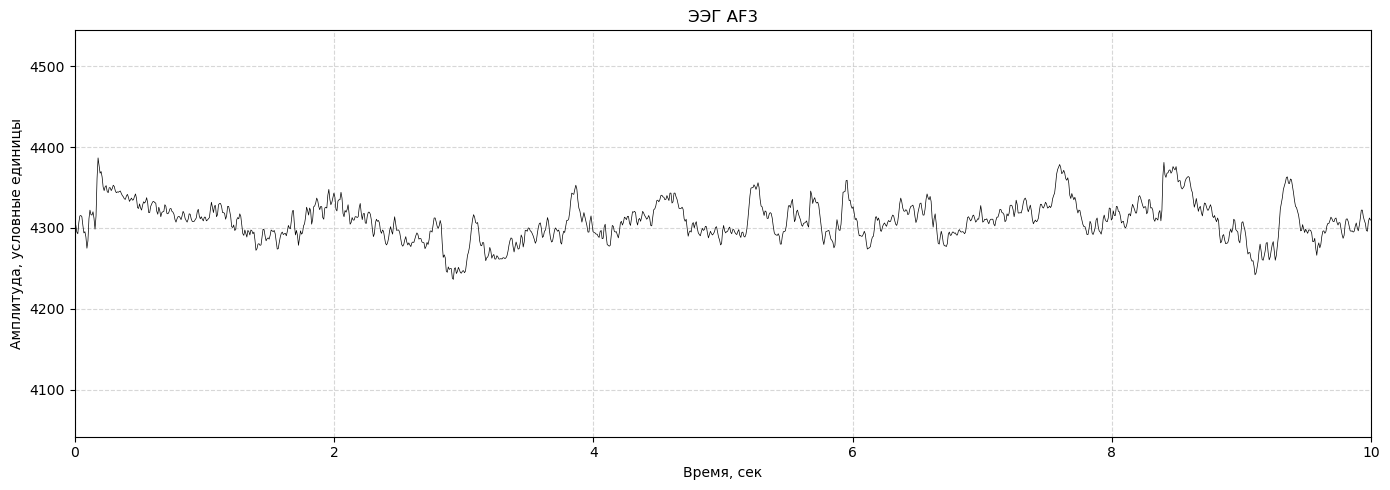

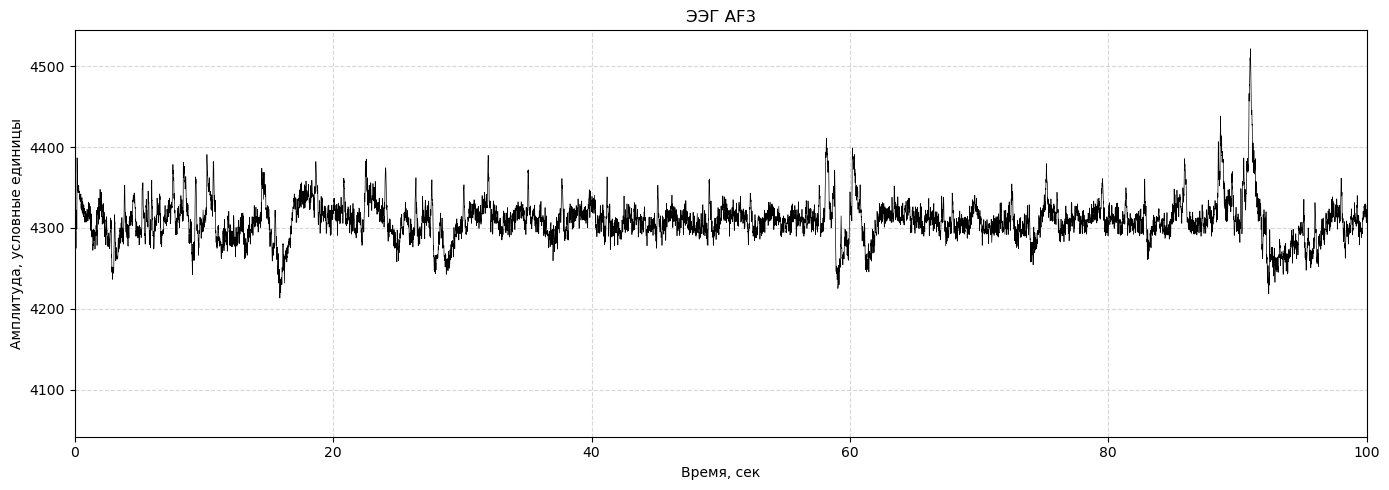

In [645]:
df = eeg_exp

channel = 'EEG.AF3'

timestamps = df['Timestamp'].values 
eeg_af3 = df[channel].values

valid = ~np.isnan(eeg_af3) & ~np.isnan(timestamps)
t = timestamps[valid]
y = eeg_af3[valid]

t_rel = t - t[0]

print(f"Длительность записи: {t_rel[-1]:.1f} сек")
print(f"Количество отсчётов: {len(y)}")

plt.figure(figsize=(14, 5))
plt.plot(t_rel, y, color='black', linewidth=0.5)
plt.title('ЭЭГ AF3')
plt.xlabel('Время, сек')
plt.xlim(0,10)
plt.ylabel('Амплитуда, условные единицы')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(t_rel, y, color='black', linewidth=0.5)
plt.title('ЭЭГ AF3')
plt.xlabel('Время, сек')
plt.xlim(0,100)
plt.ylabel('Амплитуда, условные единицы')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Оценка частоты дискретизации: 128.07 Гц
Длина сигнала: 136739 отсчётов (~1068.3 сек)


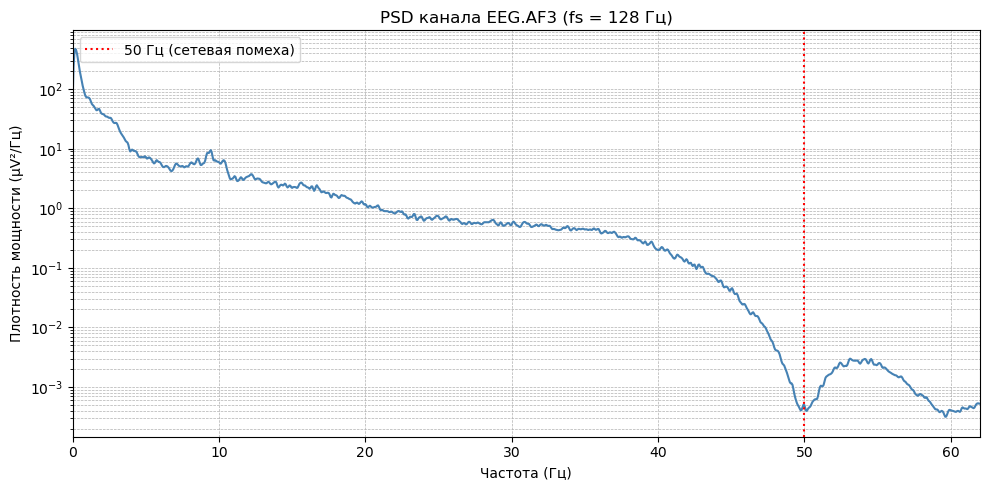

In [646]:
df = eeg_exp

# Оценка частоты дискретизации
timestamps = df['Timestamp'].dropna().values
dt = np.diff(timestamps)  # разности между соседними метками
fs_estimated = 1.0 / np.median(dt)

print(f"Оценка частоты дискретизации: {fs_estimated:.2f} Гц")


channel = 'EEG.AF3'
eeg = df[channel].dropna().values.astype(np.float64)
print(f"Длина сигнала: {len(eeg)} отсчётов (~{len(eeg)/fs:.1f} сек)")

# PSD через Welch
frequencies, psd = welch(
    eeg,
    fs=fs,
    nperseg=1024,
    noverlap=512,
    nfft=2048,
    scaling='density'
)

plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, psd, color='steelblue')
plt.title(f'PSD канала {channel} (fs = {fs} Гц)')
plt.xlabel('Частота (Гц)')
plt.ylabel('Плотность мощности (µV²/Гц)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.xlim(0, 62)
plt.axvline(50, color='red', linestyle=':', label='50 Гц (сетевая помеха)')
plt.legend()
plt.tight_layout()
plt.show()

### Вывод:

Научились считывать ЭЭГ, выглядит ок

По PSD здесь, скорее всего, применяли `0.1–40 Гц` band‑pass фильтр: после ~ `40 Гц` спектр круто уходит вниз и к `50 Гц` мощность почти нулевая, что выглядит как узкополосный режекторный фильтр на `50 Гц`

Гипотеза верна, судя по документации Emotiv имеет следующего рода фильтры: `0.2 - 45Hz, digital notch filters at 50Hz and 60Hz`

https://emotiv.gitbook.io/epoc-x-user-manual/introduction/technical-specifications

### Построение ERP

Тут пару слов нужно сказать по предобработке ЭЭГ – она уже выполнена, и вот причины, почему ее достаточно:

Полосовая фильтрация уже применена: `0.2–45 Гц` — этого достаточно для ERP (компоненты типа `N100`, `P300` лежат в этом диапазоне)

Emotiv использует внутренний CMS/DRL, но не средний референс (common average). Однако для ERP с EPOC X это приемлемо

Если эпохи содержат моргания, движения — понятное дело ERP исказится. Но Emotiv не отдаёт EOG-каналы, поэтому сложнее чистить. Однако, если в маркерах эпохи короткие, и участник сидел спокойно, то можно обойтись без ICA/регрессии

Таймлайн (порядок 24 стимулов на графике):

1. VK_JAPAN_INFO
2. VK_JAPAN_COM
3. VK_JAPAN_THR
4. TG_JAPAN_INFO
5. TG_JAPAN_COM
6. TG_JAPAN_THR
7. TG_MUSK_INFO
8. TG_MUSK_COM
9. TG_MUSK_THR
10. VK_MASK_INFO
11. VK_MUSK_COM
12. VK_MUSK_THR
13. VK_BORISOV_INFO
14. VK_BORISOV_COM
15. VK_BORISOV_THR
16. TG_BORISOV_INFO
17. TG_BORISOV_COM
18. TG_BORISOV_THR
19. TG_EGE_INFO
20. TG_EGE_COM
21. TG_EGE_THR_1
22. TG_EGE_THR_2
23. VK_EGE_INFO
24. VK_EGE_COM

In [793]:
BASE_DIR = Path("EEG RAW DATA (INFOPOVODI)")
ERP_DIR = Path("ERP_RESULTS")
ERP_DIR.mkdir(parents=True, exist_ok=True)

EEG_CHANNELS = [
    'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1',
    'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4'
]
MNE_CH_NAMES = [ch.replace('EEG.', '') for ch in EEG_CHANNELS]

FS = 128
PRE_STIM = 0.2
POST_STIM = 1.0
T_MIN = -PRE_STIM
T_MAX = POST_STIM
N_SAMPLES = int((PRE_STIM + POST_STIM) * FS)

Связка двух файлов делается по общему времени в секундах (`Timestamp` / `timestamp`).

В EEG‑файле у каждого сэмпла есть колонка `Timestamp` — глобальное время записи для этого отсчёта.

В файле маркеров у каждого события есть колонка `timestamp` — глобальное время предъявления стимула. Для каждого события берётся его timestamp и ищется ближайший отсчёт в ряду EEG

In [796]:
def find_epochs_for_stimulus(markers_df, raw_df, stimulus_name):
    stim_rows = markers_df[markers_df['marker_value'] == stimulus_name]
    if stim_rows.empty:
        return []

    epochs = []
    timestamps_raw = raw_df['Timestamp'].values

    for _, row in stim_rows.iterrows():
        onset_time = row['timestamp']
        idx = np.searchsorted(timestamps_raw, onset_time)
        start_idx = idx - int(PRE_STIM * FS)
        end_idx = idx + int(POST_STIM * FS)

        if start_idx < 0 or end_idx > len(raw_df):
            continue

        epoch_dict = {}
        valid_epoch = True
        for ch in EEG_CHANNELS:
            if ch not in raw_df.columns:
                print(f"Канал {ch} отсутствует в RAW")
                valid_epoch = False
                break
            sig = raw_df[ch].iloc[start_idx:end_idx].values
            if len(sig) != N_SAMPLES:
                valid_epoch = False
                break
            epoch_dict[ch] = sig.astype(np.float64)
        if valid_epoch:
            epochs.append(epoch_dict)
    return epochs

Следующая функция делает полный цикл «от сырых файлов до ERP‑картинок» для заданных респондентов и стимулов

До стимула (предстимульный интервал, baseline) — 200 мс. После стимула — 1000 мс. ERP сохраняется в папке `ERP_RESULTS`

In [799]:
def compute_and_plot_erp(participants, stimuli, times_for_topo=(0.1, 0.2, 0.3)):
    for stim in stimuli:
        print(f"\n СТИМУЛ: {stim}")
        all_epochs_flat = []


        for p in participants:
            print(f" Респондент {p}...")
            marker_file = BASE_DIR / f"{p}_Восприятие инфоповодов_intervalMarker.csv"
            raw_path = BASE_DIR / f"{p}_RAW DATA.csv"

            if not marker_file.exists():
                print("нет файла маркеров")
                continue

            markers = pd.read_csv(marker_file)

            if raw_path is None:
                print("нет RAW-файла")
                continue


            try:
                with open(raw_path, 'r', encoding='utf-8') as f:
                    header = f.readline()
                sep = ';' if header.count(';') > header.count(',') else ','
                raw = pd.read_csv(raw_path, sep=sep, skiprows=1, engine="python")
            except Exception as e:
                print(f" ошибка чтения RAW: {e}")
                continue

            epochs = find_epochs_for_stimulus(markers, raw, stim)
            all_epochs_flat.extend(epochs)

        print(f"  Найдено эпох: {len(all_epochs_flat)}")
        if not all_epochs_flat:
            print("  Эпох нет, пропускаем стимул")
            continue

        erp_channels = {}
        bl_end = int(PRE_STIM * FS)

        for ch in EEG_CHANNELS:
            sigs = np.array([ep[ch] for ep in all_epochs_flat])
            baseline_mean = np.mean(sigs[:, :bl_end], axis=1, keepdims=True)
            sigs_corr = sigs - baseline_mean
            erp_channels[ch] = np.mean(sigs_corr, axis=0)

        data = np.vstack([erp_channels[ch] for ch in EEG_CHANNELS])

        info = mne.create_info(
            ch_names=MNE_CH_NAMES,
            sfreq=FS,
            ch_types='eeg'
        )
        montage = mne.channels.make_standard_montage('standard_1020') 
        info.set_montage(montage)

        evoked = mne.EvokedArray(
            data,
            info,
            tmin=T_MIN,
            comment=stim
        )

        fig1 = evoked.plot(
            spatial_colors=True,
            gfp=False,
            window_title=f"ERP: {stim}",
            time_unit='s'
        )

        evoked.plot_topomap(
            times=list(times_for_topo),
            ch_type='eeg',
            time_unit='s',
            contours=0
        )

        fig1_path = ERP_DIR / f"ERP_{stim}_topomap.png"
        fig1.savefig(fig1_path, dpi=300, bbox_inches='tight')
        plt.close(fig1)

### Пример вызова функции


 СТИМУЛ: VK_JAPAN_INFO
 Респондент 1...
  Найдено эпох: 1


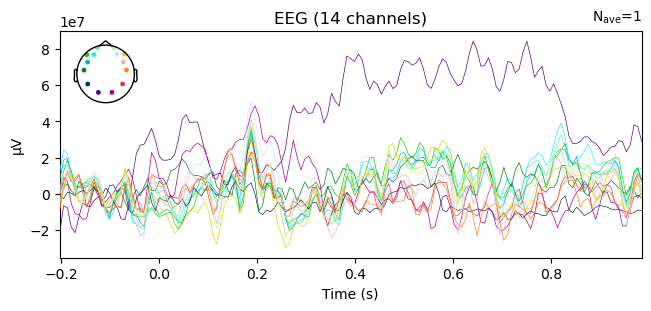

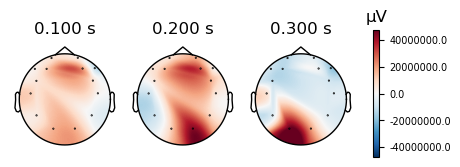

In [666]:
PARTICIPANTS = list(range(1, 2))
STIMULI = ["VK_JAPAN_INFO"]
compute_and_plot_erp(PARTICIPANTS, STIMULI)

### Финальный вызов команды с сохранением всех ERP в папку `ERP_RESULTS`

Для запуска кода пришлось подравнять имя для файла 4 респондента


 СТИМУЛ: VK_MASK_INFO
 Респондент 1...
 Респондент 2...
 Респондент 3...
 Респондент 4...
 Респондент 5...
 Респондент 6...
 Респондент 7...
 Респондент 8...
 Респондент 9...
 Респондент 10...
 Респондент 11...
 Респондент 12...
 Респондент 13...
 Респондент 14...
 Респондент 15...
 Респондент 16...
  Найдено эпох: 16


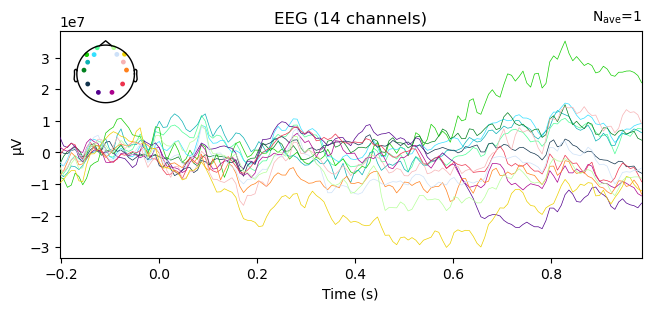

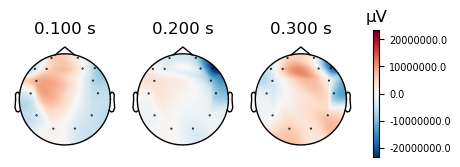

In [801]:
PARTICIPANTS = list(range(1, 17))
STIMULI = ["VK_MASK_INFO"
]
compute_and_plot_erp(PARTICIPANTS, STIMULI)

#### Выводы:

Построились ERP графики

Амплитуды находятся в пределах нескольких микровольт (с учётом того, что ось помечена µV, а масштаб 1e7 задаёт только внутреннее представление чисел в matplotlib), то есть физически это типичный уровень кортикальных ответов на зрительные стимулы без ярко выраженного P300/SSVEP

Волны разных каналов относительно синхронны, видны медленные компоненты в диапазоне сотен миллисекунд, и нет явных резких выбросов, похожих на артефакты моргания или движения, так что для иллюстрации «усреднённый ответ на просмотр контента» график вполне пригоден

Теперь давайте попробуем проанализировать метрики, собираемые с нейроинтерфейса

## Задача 2: графики по эмоциям

**Что нужно сделать?** 

построить по каждому стимулу по всем респондентам графики по эмоциональным метрикам (stress, interest, engagement, attention и т.д.) от ПО Emotiv.


**Что нужно взять?**

сырые данные с emotiv. Они выглядят так: *номер респондента*_RAW DATA - это файл с сырыми данными с момента, как мы включили запись ЭЭГ до момента, когда мы её выключили. Он нам важен, потому что там есть данные по эмоциональным метрикам (stress, interest, engagement, и т.д.). файлы с интервальными маркерами: *номер респондента*_Восприятие инфоповодов_intervalMarker.csv - это файл с маркерами событий, в том числе и самих стимулов.


**Далее:**
- нужно синхронизировать эти файлы по событиям: в сырых данных нет маркеров по стимулам (в какие моменты времени какие стимулы демонстрировались). Поэтому нужно взять эти маркеры из файлов с интервальными маркерами и внести их в сырые данные.
- усреднить данные по респондентам
- построить общие графики по изменению эмоциональных метрик по каждому стимулу: всего получится 24 графика (не забудь взять время до демонстрации стимула, чтобы сравнить изменение эмоциональных метрик с бэйслайном).

Будем брать scaled метрики, это нормированная оценка в условной шкале (обычно близко к 0–100): `'PM.Attention.Scaled','PM.Engagement.Scaled', 'PM.Excitement.Scaled', 'PM.Stress.Scaled', 'PM.Relaxation.Scaled', 'PM.Interest.Scaled',  'PM.Focus.Scaled'`

Частота дискретизации для этих метрик `0.1 Гц`

Будем работать с `RAW DATA` (тут тоже содержатся метрики) и `Восприятие инфоповодов_intervalMarker.csv`

In [741]:
base_dir = Path("./EEG RAW DATA (INFOPOVODI)")

markers_path = base_dir / "1_Восприятие инфоповодов_intervalMarker.csv"

# чтение маркеров
markers = pd.read_csv(markers_path)
markers[14:23]

,latency,duration,type,marker_value,key,timestamp,marker_id
14,137.253511,14.999658,RELAX,RELAX,-1,1.743410e+09,15
15,152.253169,10.010184,VK_JAPAN_INFO,VK_JAPAN_INFO,-1,1.743410e+09,16
16,162.271161,14.999658,RELAX,RELAX,-1,1.743410e+09,17
17,177.270819,10.002375,VK_JAPAN_COM,VK_JAPAN_COM,-1,1.743410e+09,18
18,187.273194,15.015275,RELAX,RELAX,-1,1.743410e+09,19
19,202.288469,10.002375,VK_JAPAN_THR,VK_JAPAN_THR,-1,1.743410e+09,20
20,212.290844,15.015275,RELAX,RELAX,-1,1.743410e+09,21
21,227.306119,2.451792,CQ,NaN,-1,1.743410e+09,22
22,227.306119,2.451792,sensor_check,true,-1,1.743410e+09,23


10 секунд длится стимул, 15 отдых, затем снова стимул. При частоте 0.1 Гц у обновления метрик за 10 секунд стимула можно получить в лучшем случае 1 точку метрики (иногда ни одной), поэтому классический «эпохинг» как для ЭЭГ здесь не работает. Поэтому будем рассматривать окно `[-15,15]` сек

In [690]:
EMO_COLS = [
    'PM.Attention.Scaled', 'PM.Engagement.Scaled', 'PM.Excitement.Scaled',
    'PM.Stress.Scaled', 'PM.Relaxation.Scaled', 'PM.Interest.Scaled',
    'PM.Focus.Scaled'
]

FS_EMO = 0.1          # Гц (Emotiv даёт метрики ~0.1 Гц)
PRE_STIM = 15.0       # секунд до стимула
POST_STIM = 15.0      # секунд после стимула
T_MIN = -PRE_STIM
T_MAX = POST_STIM

N_TIME = int((PRE_STIM + POST_STIM) * FS_EMO) + 1
TIME_AXIS = np.linspace(T_MIN, T_MAX, N_TIME)

In [716]:
def load_raw_experiment(p):
    raw_path = BASE_DIR / f"{p}_RAW DATA.csv"
    with open(raw_path, 'r', encoding='utf-8') as f:
                    header = f.readline()
    sep = ';' if header.count(';') > header.count(',') else ','
    return pd.read_csv(raw_path, sep=sep, skiprows=1, engine="python")


def load_markers(p):
    marker_file = BASE_DIR / f"{p}_Восприятие инфоповодов_intervalMarker.csv"
    if not marker_file.exists():
        return None
    return pd.read_csv(marker_file)


def extract_emo_epoch(raw_df, onset_time):
    cols = ['Timestamp'] + EMO_COLS
    df = raw_df[cols].copy()

    # иногда Emotiv даёт NaN в метриках — линейно интерполируем по времени
    df = df.sort_values('Timestamp')
    df[EMO_COLS] = df[EMO_COLS].interpolate(method='linear', limit_direction='both')

    rel_time = df['Timestamp'].values - onset_time

    # берём только нужное окно
    mask = (rel_time >= T_MIN) & (rel_time <= T_MAX)
    if not mask.any():
        return None

    rel_time_window = rel_time[mask]
    data_window = df.loc[mask, EMO_COLS].values

    epoch = {}
    for i, col in enumerate(EMO_COLS):
        epoch[col] = np.interp(TIME_AXIS, rel_time_window, data_window[:, i])
    return epoch


def compute_emotion_curves(participants, stimuli):
    result = {stim: {m: [] for m in EMO_COLS} for stim in stimuli}

    for stim in stimuli:
        print(f"\n СТИМУЛ: {stim}")
        for p in participants:
            print(f"  Респондент {p}")
            markers = load_markers(p)
            raw = load_raw_experiment(p)
            if markers is None or raw is None:
                continue

            stim_rows = markers[markers['marker_value'] == stim]
            if stim_rows.empty:
                continue

            for _, row in stim_rows.iterrows():
                onset_time = row['timestamp']
                epoch = extract_emo_epoch(raw, onset_time)
                if epoch is None:
                    continue
                for m in EMO_COLS:
                    result[stim][m].append(epoch[m])

    # усреднение по эпохам (и по респондентам)
    for stim in stimuli:
        for m in EMO_COLS:
            if result[stim][m]:
                result[stim][m] = np.mean(np.vstack(result[stim][m]), axis=0)
            else:
                result[stim][m] = np.full_like(TIME_AXIS, np.nan)

    return result


In [718]:
def plot_emotion_curves(emo_results, stimuli, save_dir="EMO_RESULTS"):
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)

    for stim in stimuli:
        curves = emo_results[stim]

        # один рисунок на стимул: все метрики на одном графике
        plt.figure(figsize=(10, 5))
        for m in EMO_COLS:
            if np.all(np.isnan(curves[m])):
                continue
            plt.plot(TIME_AXIS, curves[m], label=m.replace('PM.', '').replace('.Scaled', ''))

        plt.axvline(0, color='k', linestyle='--', linewidth=1)
        plt.xlabel("Время относительно стимула (с)")
        plt.ylabel("Scaled значение (0–100)")
        plt.title(f"Эмоциональные метрики: {stim}")
        plt.legend(loc="best", fontsize=8)
        plt.grid(alpha=0.3)

        out_path = save_dir / f"EMO_{stim}.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()

### Пример вызова функции


 СТИМУЛ: VK_JAPAN_INFO
  Респондент 1


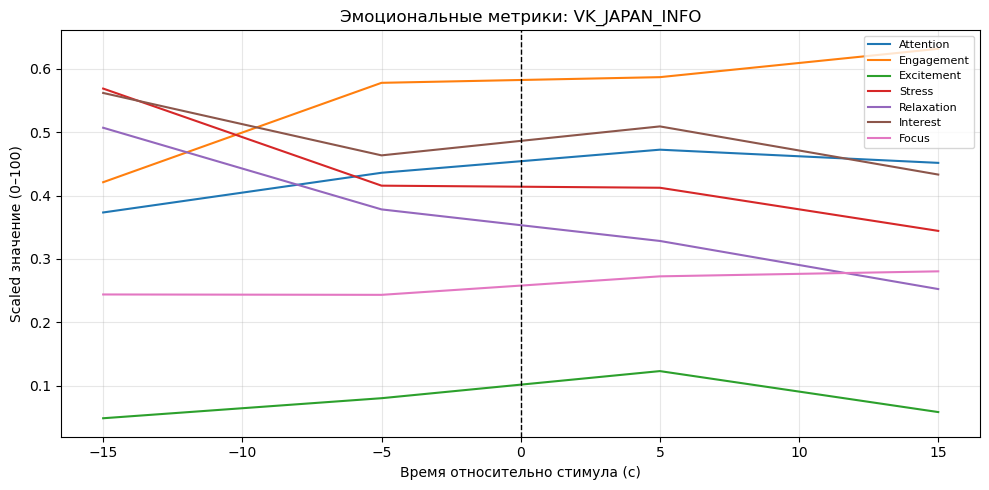

In [721]:
PARTICIPANTS = list(range(1, 2))
STIMULI = ["VK_JAPAN_INFO"]

emo_results = compute_emotion_curves(PARTICIPANTS, STIMULI)

plot_emotion_curves(emo_results, STIMULI)

### Финальный вызов команды с сохранением всех графиков в папку `EOM_RESULTS`


 СТИМУЛ: VK_MASK_INFO
  Респондент 1
  Респондент 2
  Респондент 3
  Респондент 4
  Респондент 5
  Респондент 6
  Респондент 7
  Респондент 8
  Респондент 9
  Респондент 10
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 14
  Респондент 15
  Респондент 16


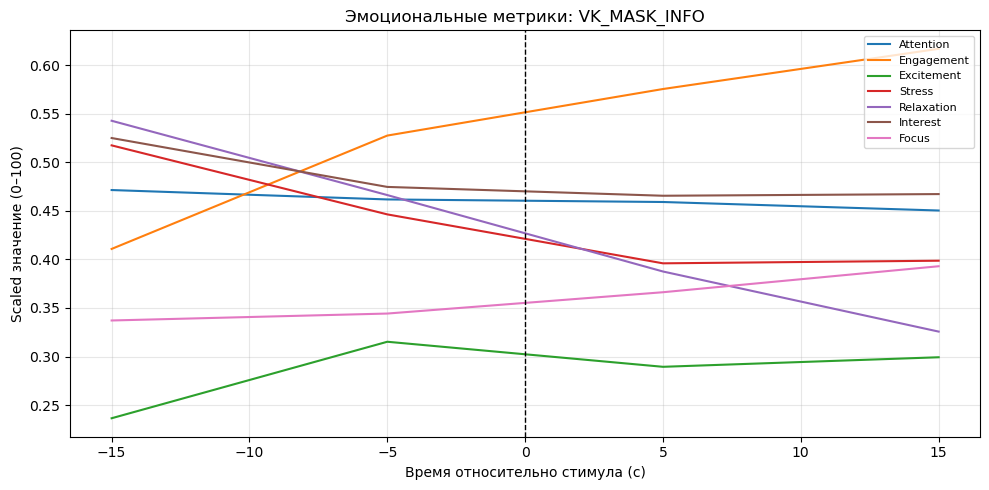

In [759]:
PARTICIPANTS = list(range(1, 17))
STIMULI = [
    "VK_JAPAN_INFO", "VK_JAPAN_COM", "VK_JAPAN_THR",
    "TG_JAPAN_INFO", "TG_JAPAN_COM", "TG_JAPAN_THR",
    "TG_MUSK_INFO", "TG_MUSK_COM", "TG_MUSK_THR",
    "VK_MASK_INFO", "VK_MUSK_COM", "VK_MUSK_THR",
    "VK_BORISOV_INFO", "VK_BORISOV_COM", "VK_BORISOV_THR",
    "TG_BORISOV_INFO", "TG_BORISOV_COM", "TG_BORISOV_THR",
    "TG_EGE_INFO", "TG_EGE_COM", "TG_EGE_THR_1", "TG_EGE_THR_2",
    "VK_EGE_INFO", "VK_EGE_COM"
]

emo_results = compute_emotion_curves(PARTICIPANTS, STIMULI)
plot_emotion_curves(emo_results, STIMULI)

### Задача со звёздочкой:
после того, как удастся построить общие графики, таким же образом нужно построить графики по полу:

1.1. то есть 24 графика по женщинам. Номера респондентов-женщин: 1, 7, 9, 11,
12, 13, 15, 16

1.2. и 24 графика по мужчинам. Номера респондентов-мужчин: пилот, 2, 3, 4,
5, 6, 8, 10, 14

#### Женщины, сохраняем в `EMO_RESULTS_FEMALE`


 СТИМУЛ: VK_JAPAN_INFO
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: VK_JAPAN_COM
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: VK_JAPAN_THR
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: TG_JAPAN_INFO
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: TG_JAPAN_COM
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: TG_JAPAN_THR
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респондент 13
  Респондент 15
  Респондент 16

 СТИМУЛ: TG_MUSK_INFO
  Респондент 1
  Респондент 7
  Респондент 9
  Респондент 11
  Респондент 12
  Респонде

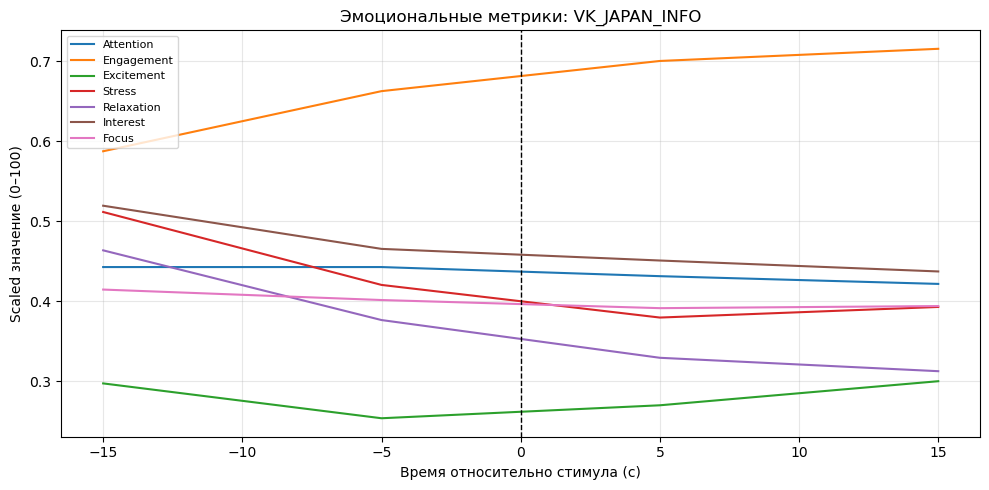

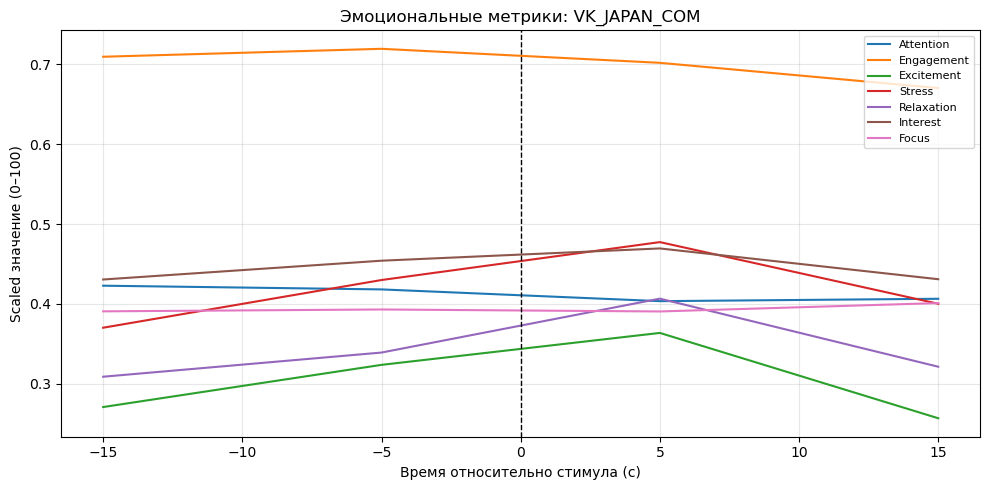

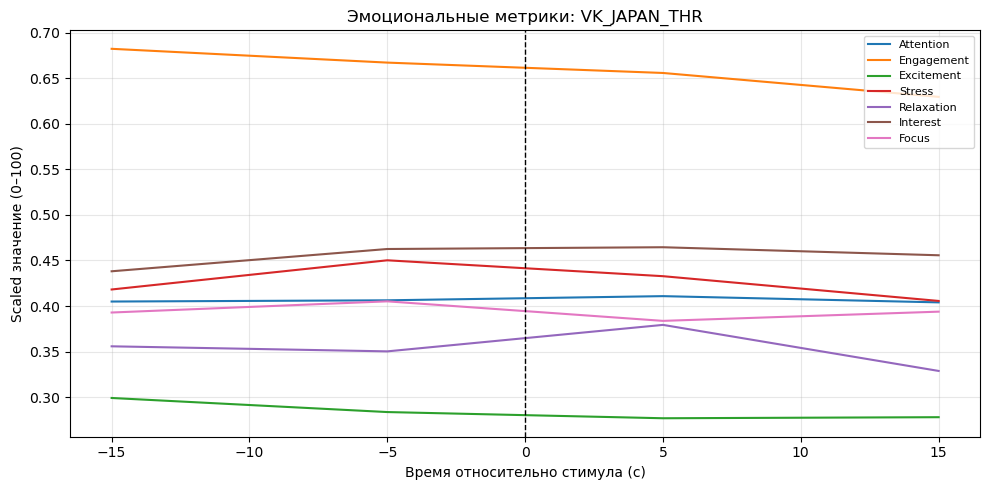

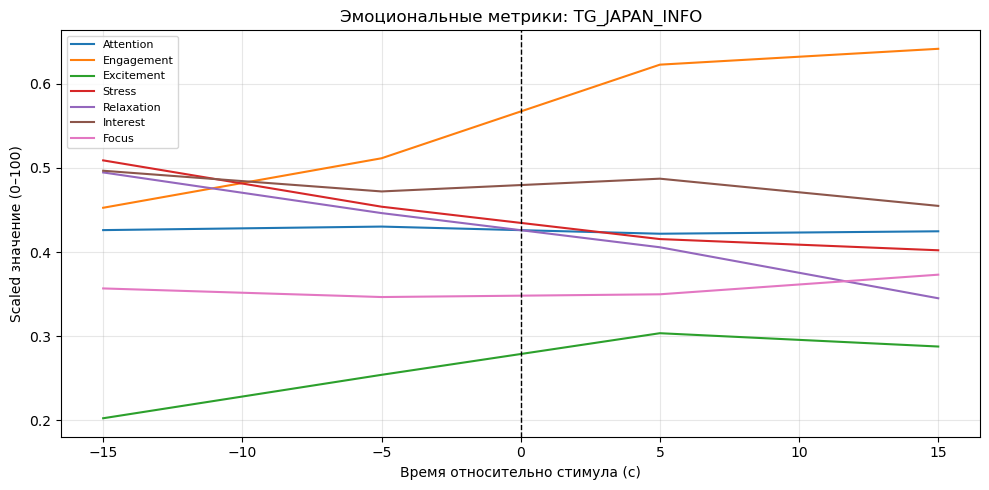

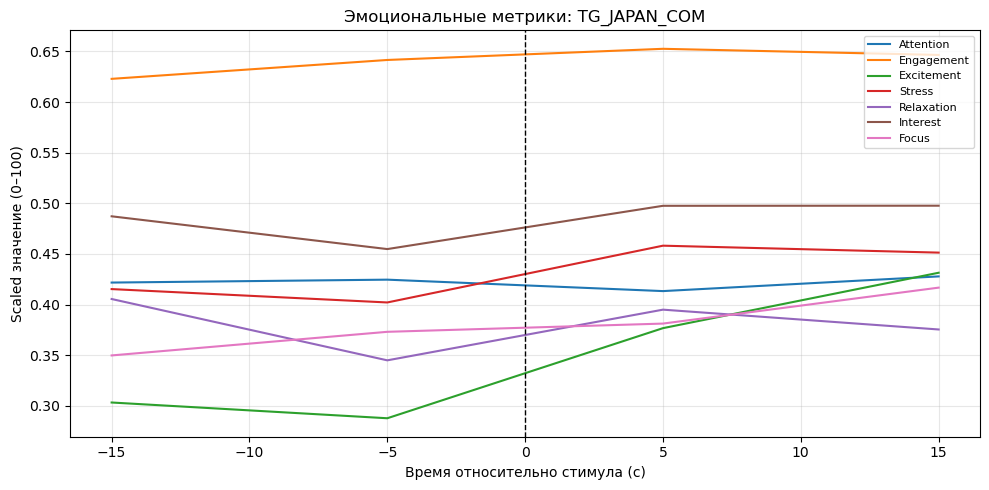

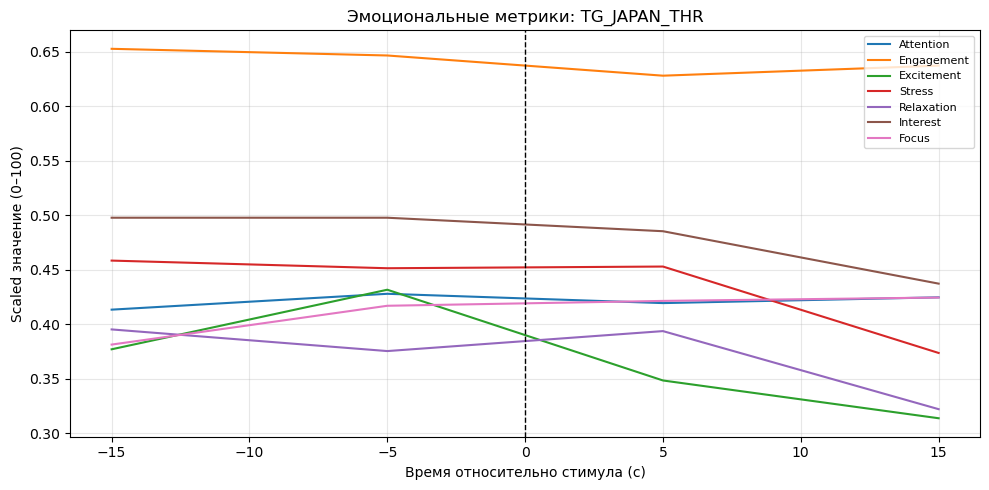

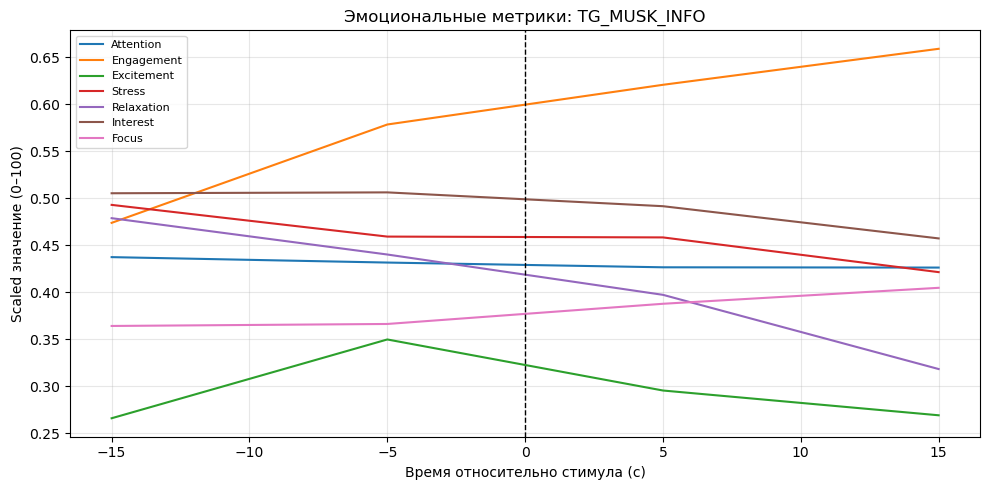

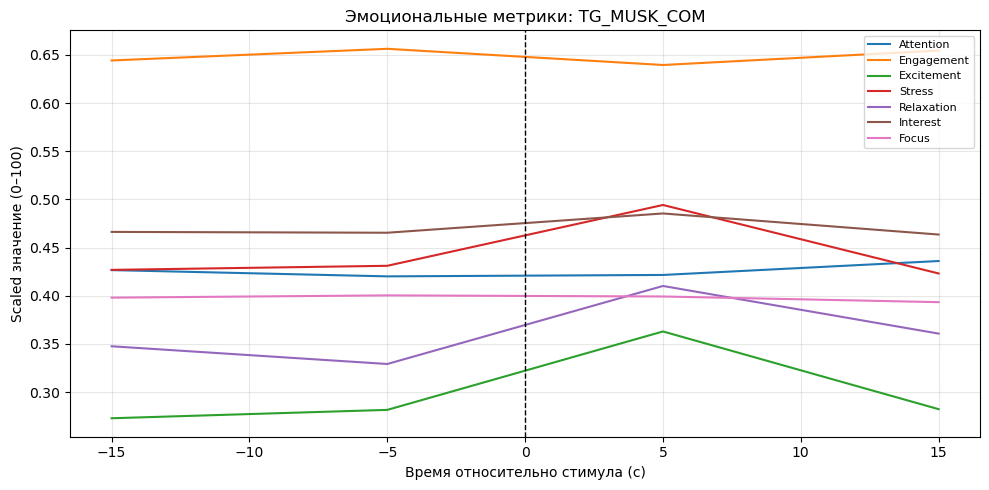

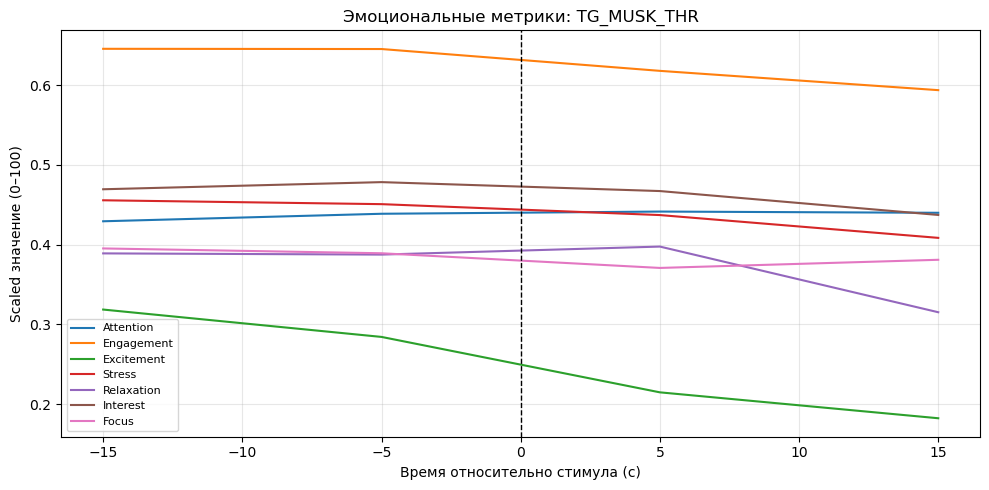

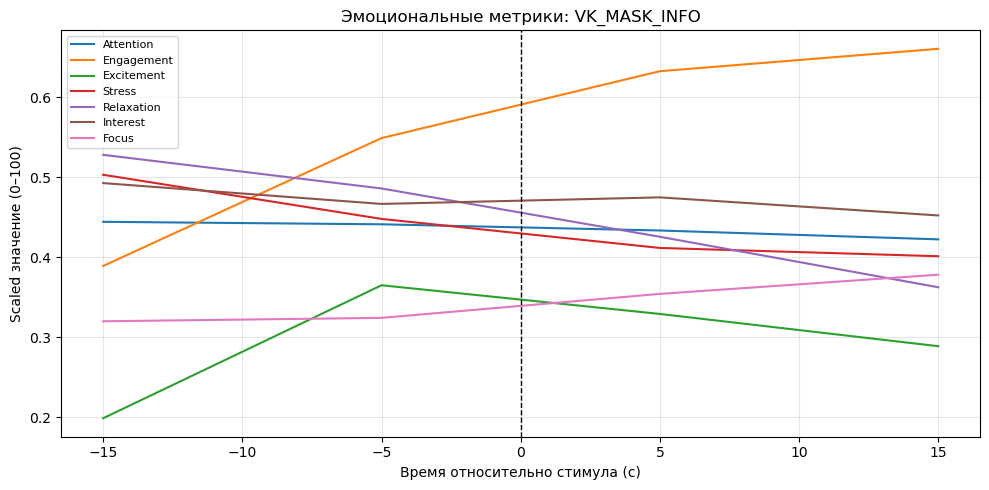

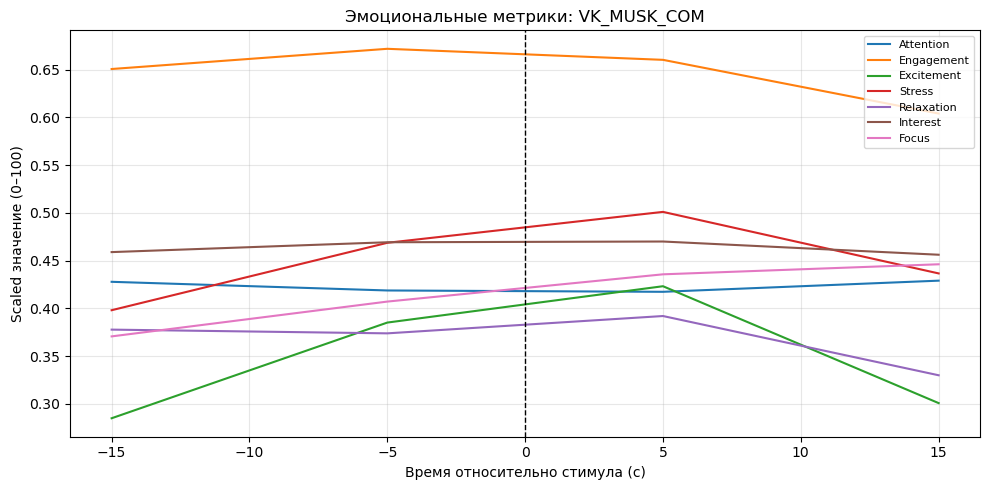

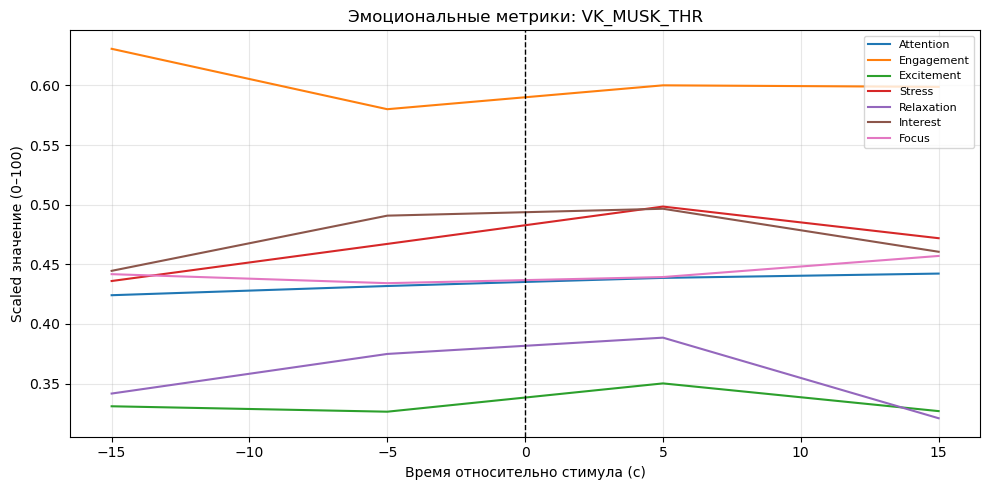

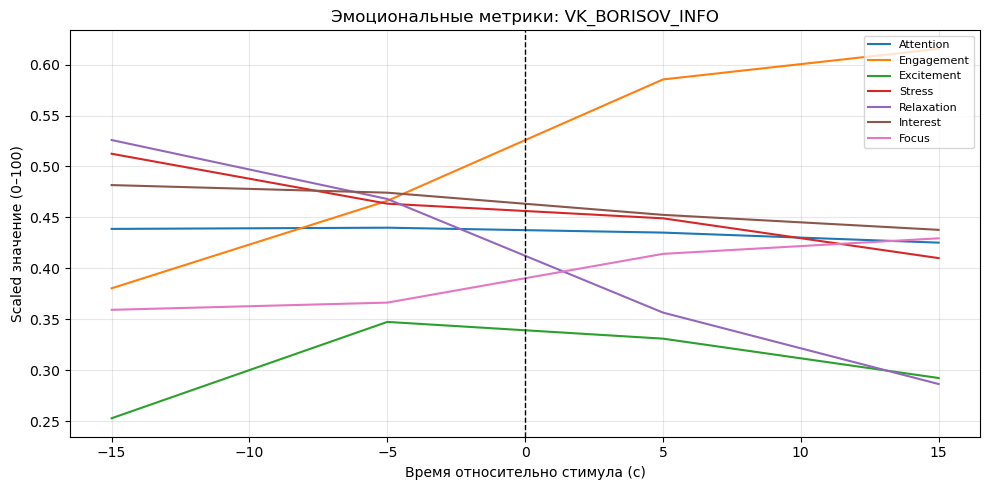

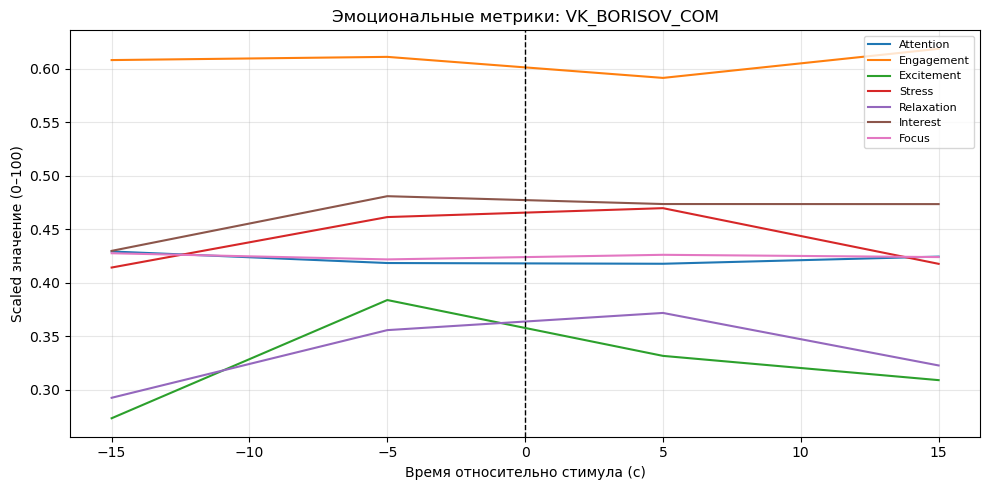

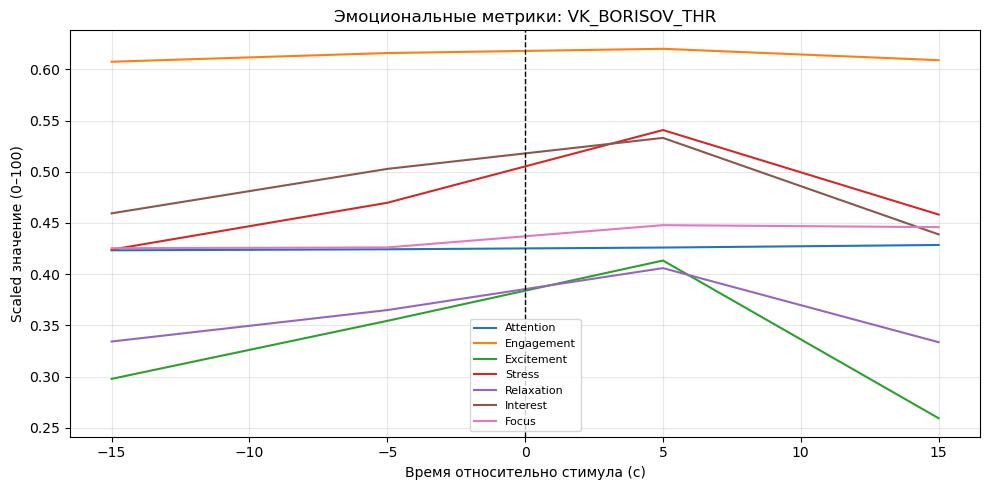

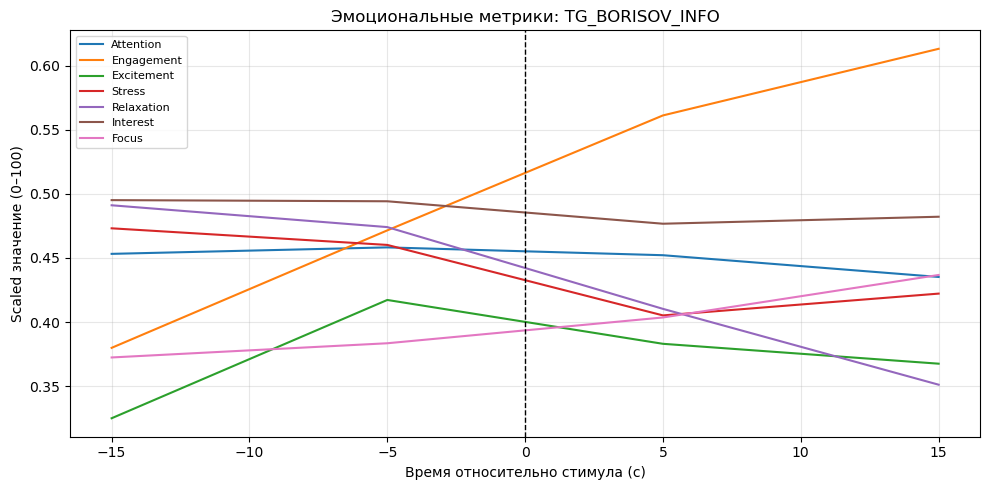

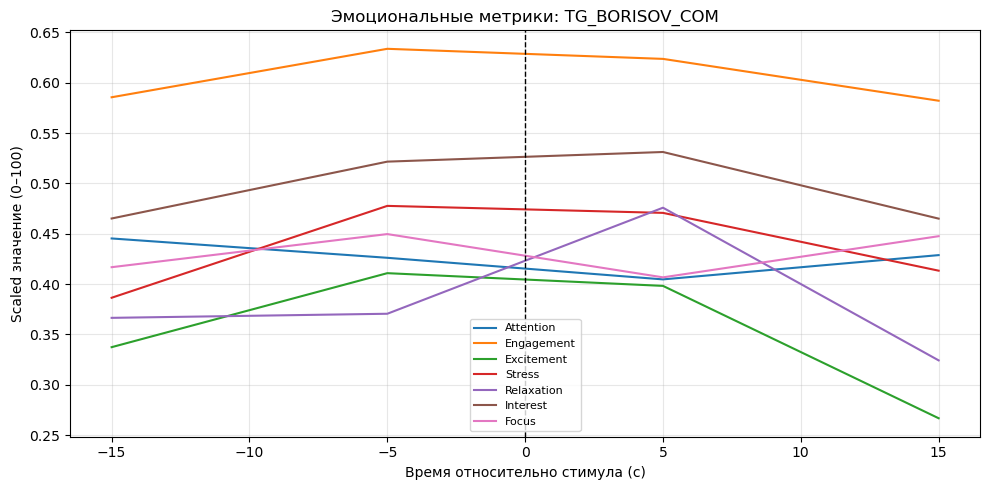

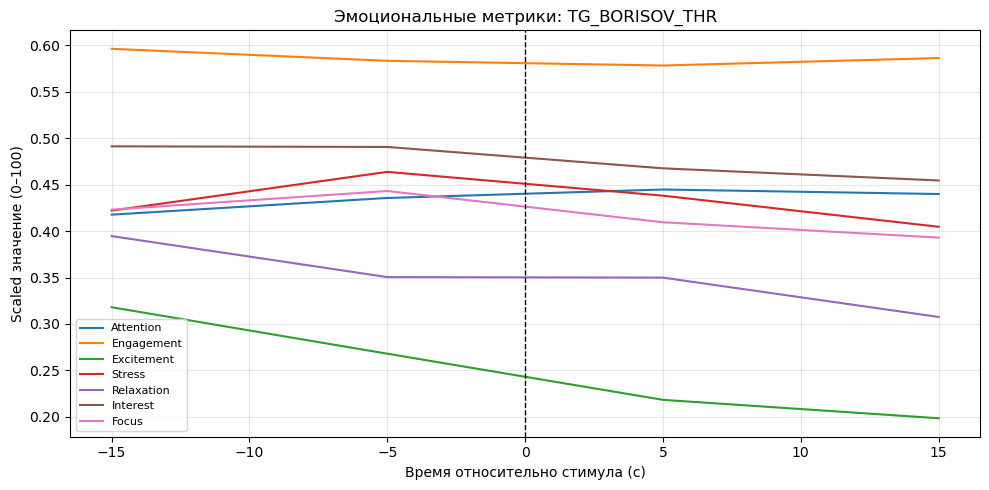

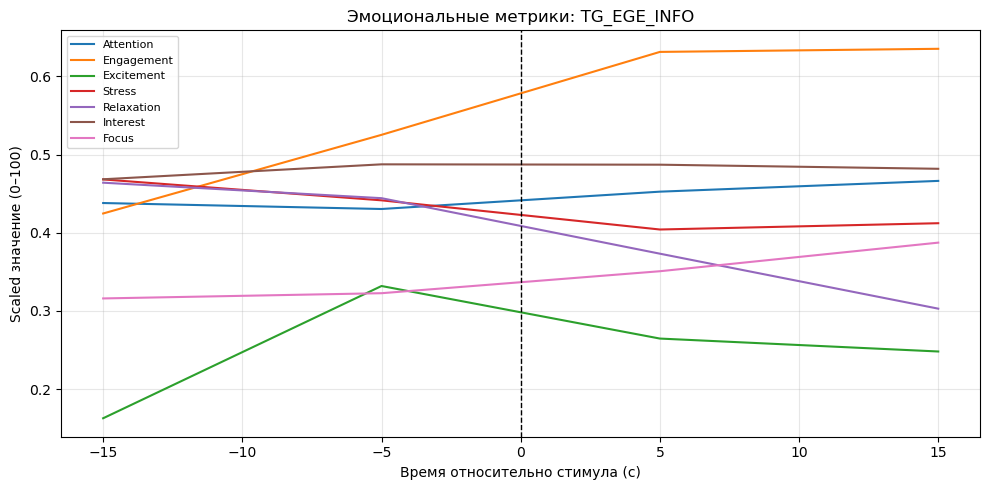

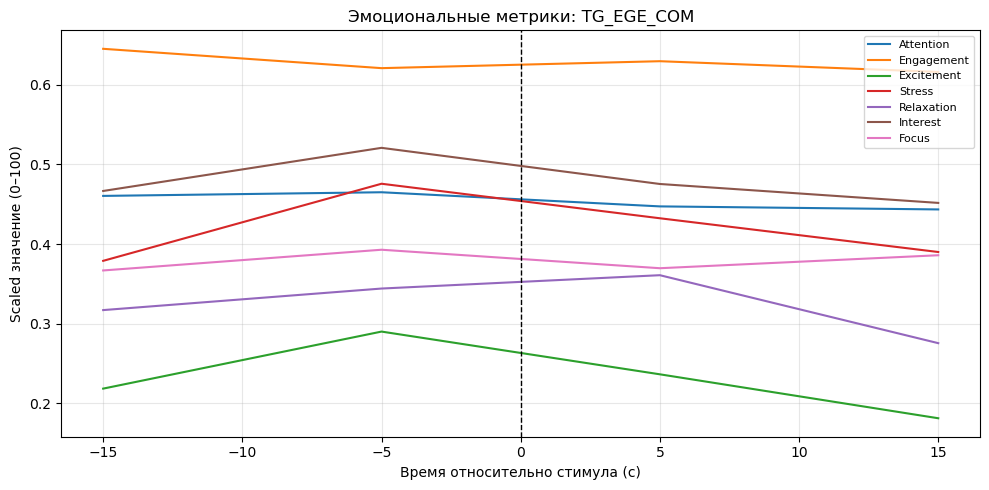

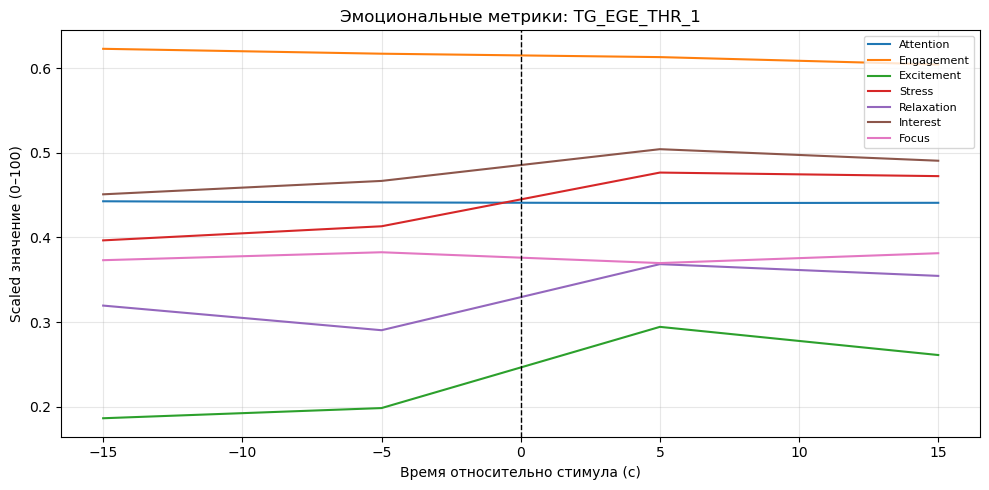

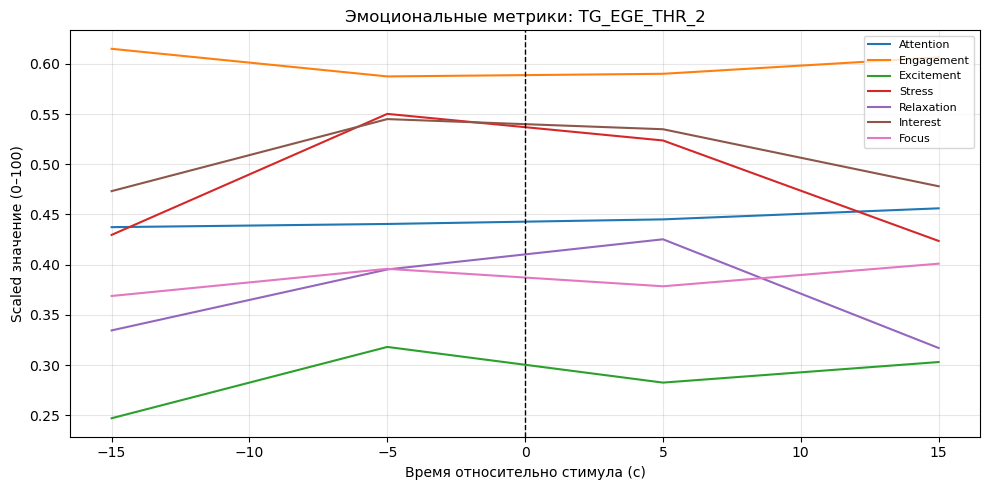

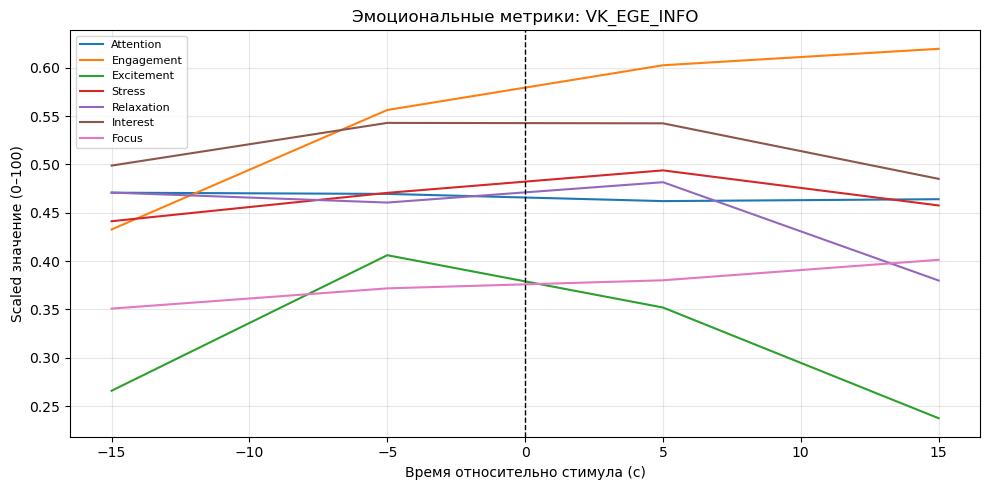

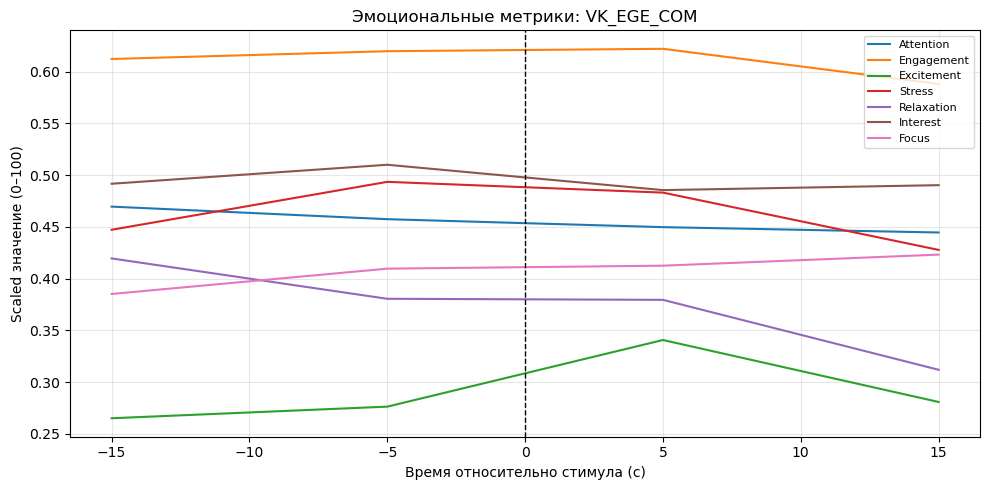

In [767]:
PARTICIPANTS = [1, 7, 9, 11, 12, 13, 15, 16]
STIMULI = [
    "VK_JAPAN_INFO", "VK_JAPAN_COM", "VK_JAPAN_THR",
    "TG_JAPAN_INFO", "TG_JAPAN_COM", "TG_JAPAN_THR",
    "TG_MUSK_INFO", "TG_MUSK_COM", "TG_MUSK_THR",
    "VK_MASK_INFO", "VK_MUSK_COM", "VK_MUSK_THR",
    "VK_BORISOV_INFO", "VK_BORISOV_COM", "VK_BORISOV_THR",
    "TG_BORISOV_INFO", "TG_BORISOV_COM", "TG_BORISOV_THR",
    "TG_EGE_INFO", "TG_EGE_COM", "TG_EGE_THR_1", "TG_EGE_THR_2",
    "VK_EGE_INFO", "VK_EGE_COM"
]

emo_results = compute_emotion_curves(PARTICIPANTS, STIMULI)
plot_emotion_curves(emo_results, STIMULI, save_dir="EMO_RESULTS_FEMALE")

#### Мужчины, сохраняем в `EMO_RESULTS_MALE`


 СТИМУЛ: VK_MASK_INFO
  Респондент 2
  Респондент 3
  Респондент 4
  Респондент 5
  Респондент 6
  Респондент 8
  Респондент 10
  Респондент 14


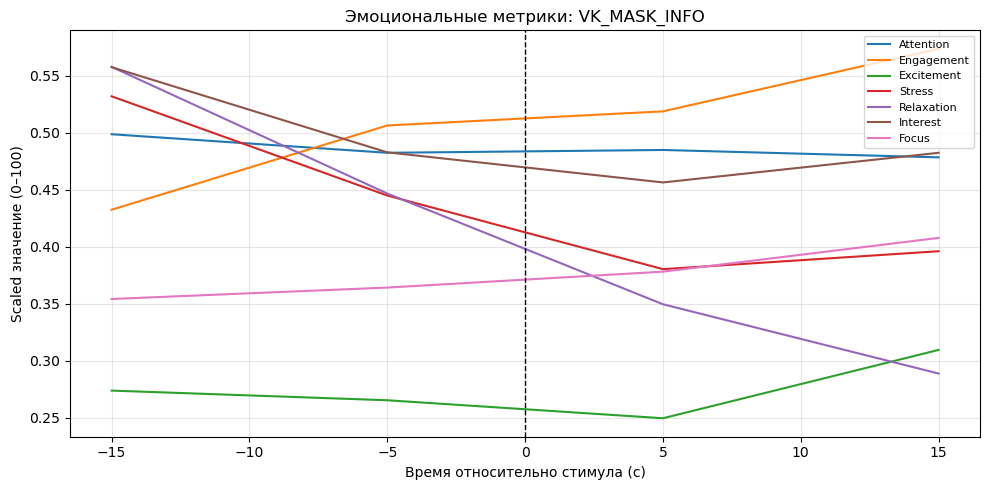

In [777]:
PARTICIPANTS = [2, 3, 4, 5, 6, 8, 10, 14]
STIMULI = [
    "VK_JAPAN_INFO", "VK_JAPAN_COM", "VK_JAPAN_THR",
    "TG_JAPAN_INFO", "TG_JAPAN_COM", "TG_JAPAN_THR",
    "TG_MUSK_INFO", "TG_MUSK_COM", "TG_MUSK_THR",
    "VK_MASK_INFO", "VK_MUSK_COM", "VK_MUSK_THR",
    "VK_BORISOV_INFO", "VK_BORISOV_COM", "VK_BORISOV_THR",
    "TG_BORISOV_INFO", "TG_BORISOV_COM", "TG_BORISOV_THR",
    "TG_EGE_INFO", "TG_EGE_COM", "TG_EGE_THR_1", "TG_EGE_THR_2",
    "VK_EGE_INFO", "VK_EGE_COM"
]

emo_results = compute_emotion_curves(PARTICIPANTS, STIMULI)
plot_emotion_curves(emo_results, STIMULI, save_dir="EMO_RESULTS_MALE")

### Выводы:

Попробую сделать гипотехы/выводы на основе того, что получилось по графикам метрик от стимулов:

- `VK_JAPAN_INFO` - увеличилось `Engagement` у обоих полов
- `VK_JAPAN_THR` - увеличил `Interest` + `Stress` у мужчин
- `TG_JAPAN_INFO` - увеличилось `Engagement` у обоих полов
- `TG_MUSK_INFO` - увеличилось `Engagement` у обоих полов
- `VK_MUST_THR` - уменьшил `Interest` + `Stress` у мужщин
- `VK_BORISOV_INFO` - увеличилось `Engagement` у обоих полов
- `TG_BORISOV_INFO` - увеличилось `Engagement` у обоих полов, у женщин больше
- `TG_EGE_INFO` - увеличилось `Engagement` у обоих полов
- `VK_EGE_INFO` - увеличилось `Engagement` у обоих полов

Из проблем: Не все файлы одинаково названы по шаблону + `VK_MASK_INFO` должно быть названо `VK_MUSK_INFO`